In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

电化学模型参数

In [2]:
# 定义常量
R = 8.314
F = 96485
L = 22  # 隔膜电导率参数，需要根据实际情况进行调整
A_e = 0.0025
w_e = 0.003  # 电极厚度，需要根据实际情况进行调整
V_e = A_e * w_e
w_c = 0.015  # 集流体厚度，需要根据实际情况进行调整
theta_c = 91000  # 集流体电导率，需要根据实际情况进行调整
w_m = 0.000127  # 离子交换膜厚度，需要根据实际情况进行调整
E_p0 = 1.004
E_n0 = -0.26
n_d = 2.5
C_Hp0 = 3850
C_Hn0 = 3030
C_H2Op0 = 44600

# 电池参数 S, k_p, k_n, theta_e
S, k_p, k_n, theta_e = 133.2985382080078, 1.2078422514605336e-05, 1.2077945029886905e-05, 47.493289947509766

函数

In [3]:
def get_con(SoC, C_V0, C_Hp0, C_Hn0, C_H2Op0):
    C_2 = C_V0*SoC
    C_3 = C_V0*(1 - SoC)
    C_4 = C_V0*(1 - SoC)
    C_5 = C_V0*SoC
    C_Hn = C_Hn0 + C_V0*SoC
    C_Hp = C_Hp0 + C_V0*SoC
    C_H2Op = C_H2Op0 - (1 + n_d)*C_V0*SoC
    return C_2, C_3, C_4, C_5, C_Hn, C_Hp, C_H2Op


def E_con(T, I, Q, C_2, C_3, C_4, C_5):
    E_con_p = torch.empty(len(I))
    E_con_n = torch.empty(len(I))

    for i in range(len(I)):
        if I[i] > 0:
            E_con_p[i] = -R*T[i]/F*(-I[i]/(1.43*math.pow(10, -4)*F*math.pow(Q[i]/A_e, 0.4)*C_4[i]))
            E_con_n[i] = -R*T[i]/F*(-I[i]/(1.43*math.pow(10, -4)*F*math.pow(Q[i]/A_e, 0.4)*C_3[i]))
        

        if I[i] < 0:
            E_con_p[i] = -R*T[i]/F*(-I[i]/(1.43*math.pow(10, -4)*F*math.pow(Q[i]/A_e, 0.4)*C_5[i]))
            E_con_n[i] = -R*T[i]/F*(-I[i]/(1.43*math.pow(10, -4)*F*math.pow(Q[i]/A_e, 0.4)*C_2[i]))

    
    E_con = E_con_p + E_con_n
    
    return E_con


def E_act(T, I, S, k_p, k_n, C_2, C_3, C_4, C_5):

    E_act = R*T*2/F*(torch.asinh(I/S/V_e/2/F/k_p/torch.sqrt(C_4*C_5)) + torch.asinh(I/S/V_e/2/F/k_n/torch.sqrt(C_2*C_3)))

    return E_act


def E_ohm(theta_e, T, I):
    
    theta_m = (0.5139*L - 0.326)*torch.exp(1268*(1/303 - 1/T))

    E_ohm = (2*w_c/theta_c + 2*w_e/theta_e + w_m/theta_m)*I/A_e

    return E_ohm


def E_ocv(T, C_2, C_3, C_4, C_5, C_Hp, C_Hn, C_H2Op):
    E_ocv = E_p0 - E_n0 + R*T/F*torch.log((C_2*C_5*C_Hp*torch.pow(C_Hp, 2))/(C_3*C_4*C_Hn*C_H2Op))
    # E_ocv = E_p0 - E_n0 + R*T/F*torch.log((C_2*C_5*C_Hp*torch.pow(C_Hp, 2))/(C_3*C_4*C_Hn))

    return E_ocv

数据读取

In [4]:
excel_index = 1
df = pd.read_excel(f'data/test{excel_index}.xlsx') 

# 前 3 列和 5,6 数据读取为 dataX
dataX = df.iloc[:, [0,1,2,4,5]].values
dataX = torch.from_numpy(dataX).float()

# 第 7 列数据读取为 dataY
dataY = df.iloc[:, 6].values
dataY = torch.from_numpy(dataY).float().reshape(-1, 1)

# 输入 T(t), I(t), SoC(t), Q, C_V0
T, I, SoC, Q, C_V0 = dataX[:, 0], dataX[:, 1], dataX[:, 2], dataX[:, 3], dataX[:, 4]

端电压输出

均方误差 (MSE): 0.0015013511292636395
均方根误差 (RMSE): 0.03874727338552475


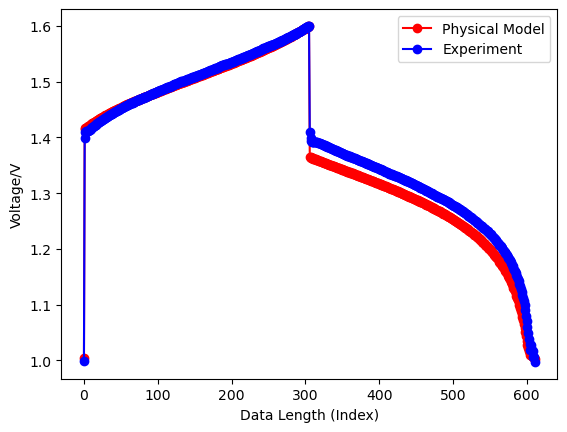

In [15]:
# 计算端电压
C_2, C_3, C_4, C_5, C_Hn, C_Hp, C_H2Op = get_con(SoC, C_V0, C_Hp0, C_Hn0, C_H2Op0)
e_con = E_con(T, I, Q, C_2, C_3, C_4, C_5)
e_act = E_act(T, I, S, k_p, k_n, C_2, C_3, C_4, C_5)
e_ohm = E_ohm(theta_e, T, I)
e_ocv = E_ocv(T, C_2, C_3, C_4, C_5, C_Hp, C_Hn, C_H2Op)
e_cell = e_con + e_act + e_ohm + e_ocv
e_cell = e_cell.float().reshape(-1, 1)

# 计算误差
# 1. 计算预测值与目标值之差
residuals = e_cell - dataY

# 2. 将残差平方
squared_residuals = residuals.pow(2)

# 3. 对所有平方残差求平均，得到MSE
mse_loss = squared_residuals.mean()

# 4. 对MSE取平方根，得到RMSE
rmse_loss = mse_loss.sqrt()

print("均方误差 (MSE):", mse_loss.item())
print("均方根误差 (RMSE):", rmse_loss.item())

# 绘制图形
plot_len =612
# 提取一个或几个特征进行可视化，假设选择第一个特征
feature_idx = 0

mode_index = 1
if mode_index == 0:
    pred_values = e_cell[:plot_len, feature_idx]
    target_values = dataY[:plot_len, feature_idx]


if mode_index == 1:
    pred_values = e_cell[-plot_len:, feature_idx]
    target_values = dataY[-plot_len:, feature_idx]


if mode_index == 2:
    pred_values = e_cell[:, feature_idx]
    target_values = dataY[:, feature_idx]


# 创建数据长度（索引）张量
data_length = torch.arange(len(pred_values))

# 绘制预测值折线图
plt.plot(data_length, pred_values, label="Physical Model", color='red', marker='o')

# 绘制目标值折线图
plt.plot(data_length, target_values, label="Experiment", color='blue', marker='o')

# 添加图例和坐标轴标签
plt.xlabel("Data Length (Index)")
plt.ylabel("Voltage/V")
plt.legend()

# 显示图形
plt.show()